# Module for DEM Acquisition Sentinel 1 Interferometry

A DEM is required in DInSAR to model and remove the topographic phase component from the interferogram, so that the remaining phase primarily represents surface deformation.

## 0. Pre-Setup

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

# get current working dir
%pwd

'/raven/u/yhsuh/coding/INSAR/examples'

[DEMManager] Using provided ROI WKT...
   Target Bounds (SNWE): 42.1225, 42.3657, 129.1263, 129.3978
   Cache Hash: 96b8c6dd3aeb -> File: dem_glo_30_96b8c6dd3aeb.tif
[DEMManager] Downloading & Stitching 'glo_30' to dem_temp/dem_glo_30_96b8c6dd3aeb.tif...


Reading tile imagery: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



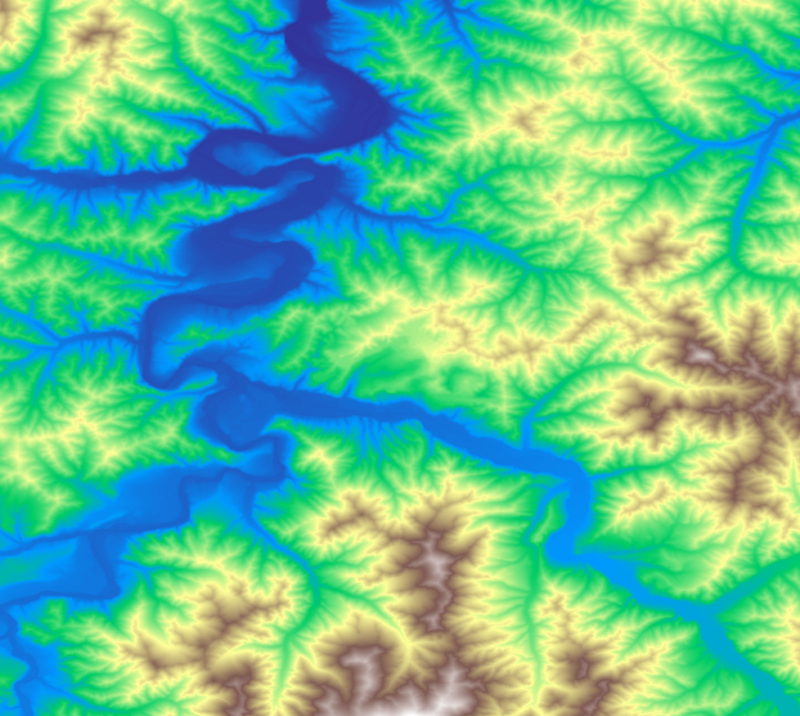

[DEMManager] Exporting to ISCE format: dem_final/dem.wgs84
   ✅ Export complete.
최종 결과물: dem_final/dem.wgs84


/u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [2]:
from modules.DEM_manager import DEMManager

# 1. 초기화
dem_man = DEMManager(save_dir="dem_final", temp_dir="dem_temp")

# 2. [Step 1] 일단 받아보기 (Fetch)
# (S1SLCManager가 있다면 slc_manager=slc_man 으로 전달)
wkt_polygon = 'POLYGON((129.22626278875606 42.26566811989898, \
                        129.29458401028302 42.263381443152866, \
                        129.29775974545447 42.222461325113535, \
                        129.22883770916536 42.22633843686002, \
                        129.22626278875606 42.26566811989898))'

dem_man.fetch_dem(roi_wkt=wkt_polygon, dem_name='glo_30')

# 3. [Step 2] 눈으로 확인 (Plot)
# 이 코드를 실행하면 지도가 나옵니다.
# "어? ROI(파란색)가 DEM(빨간 점선) 안에 잘 들어왔네?" -> 통과!
m = dem_man.plot_dem(roi_wkt=wkt_polygon)
display(m)

# 4. [Step 3] 확신이 들면 변환 (Export)
final_path = dem_man.export_to_isce(overwrite=True)

print(f"최종 결과물: {final_path}")


🔵 [Step 1] SLC Search & Selection
   Searching ASF API...
[Search] API Search Sentinel-1 SLC (2025-10-01 ~ 2026-01-10) | ALL...
[Search] Found 17 scenes.


,Scene ID,Date,Path,Frame
Index,,,,
0,S1C_IW_SLC__1SDV_20260102T213001_20260102T2130...,2026-01-02 21:30:01+00:00,134,451
1,S1A_IW_SLC__1SDV_20251229T091659_20251229T0917...,2025-12-29 09:16:59+00:00,156,134
2,S1C_IW_SLC__1SDV_20251221T213001_20251221T2130...,2025-12-21 21:30:01+00:00,134,451
3,S1A_IW_SLC__1SDV_20251217T091700_20251217T0917...,2025-12-17 09:17:00+00:00,156,134
4,S1C_IW_SLC__1SDV_20251209T213002_20251209T2130...,2025-12-09 21:30:02+00:00,134,451


[Master] Set to Idx 0. Filtered 8 incompatible scenes (Path 134).
[Select] Added Index 0
[Select] Added Index 2
   ✅ Selection Completed: Master=0, Slaves=[2]

   Checking Local Files...
[Auth] Initializing NASA Earthdata Authentication...
 [Auth] Logged in successfully.

[Download] Starting Sequential Download (2 files) to raw_data...
[1/2] Found existing file: S1C_IW_SLC__1SDV_20260102T213001_20260102T213028_005730_00B73A_280A.zip
[2/2] Found existing file: S1C_IW_SLC__1SDV_20251221T213001_20251221T213028_005555_00B135_DA0F.zip

🔵 [Step 2] DEM Generation (Intersection Mode)
[DEMManager] Calculating bounds from SLC intersection...
   Target Bounds (SNWE): 41.1975, 43.4089, 127.0735, 130.6983
   Cache Hash: 57c891e2c5ce -> File: dem_glo_30_57c891e2c5ce.tif
[DEMManager] Downloading & Stitching 'glo_30' to dem_temp/dem_glo_30_57c891e2c5ce.tif...


Reading tile imagery: 100%|██████████| 12/12 [00:00<00:00, 12.68it/s]


[DEMManager] Exporting to ISCE format: dem_data/dem.wgs84
   ✅ Export complete.
✅ DEM Process Completed: dem_data/dem.wgs84

🔵 [Step 3] Visualization
✅ Intersection found and mapped in CYAN.



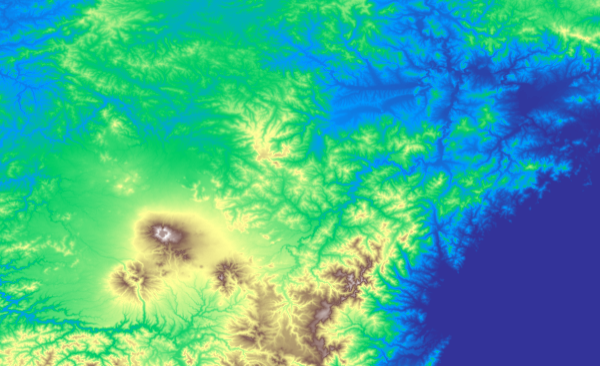

In [3]:
import os
import folium
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from modules.SLC_manager import S1SLCManager
from modules.DEM_manager import DEMManager

# ==============================================================================
# 1. Setup & Configuration
# ==============================================================================
WORK_DIR = "raw_data"
DEM_DIR = "dem_data"       # DEM 저장 경로
DEM_TEMP = "dem_temp"      # DEM 임시 경로
ROI = "POLYGON((129.2 42.2, 129.3 42.2, 129.3 42.3, 129.2 42.3, 129.2 42.2))" # 북한/중국 접경지역

# ==============================================================================
# 2. SLC Manager: Search & Selection
# ==============================================================================
print("\n🔵 [Step 1] SLC Search & Selection")

# [수정 포인트 1] 초기화 시점에 ROI를 주입해야 합니다.
dm = S1SLCManager(roi_wkt=ROI, data_dir=WORK_DIR)

# 1) Search Images
print("   Searching ASF API...")
# [수정 포인트 2] search_images 메서드에는 roi_wkt 인자를 빼야 합니다. (이미 init에서 받음)
df_results = dm.search_images(
    start_date="2025-10-01", 
    end_date="2026-01-10", 
    orbit_direction=None
)

if df_results is None or df_results.empty:
    raise ValueError("❌ 검색 결과가 없습니다. 날짜나 ROI를 확인해주세요.")

display(df_results[['Scene ID', 'Date', 'Path', 'Frame']].head())

# 2) Set Master & Slaves
# (사용자 코드 로직 반영: 0번을 Master, 나머지를 Slave로 가정)
master_idx = 0
dm.set_master(master_idx)

# Slave 선택 (검색 결과가 2개 이상이라고 가정)
# 예: 0번(Master)과 2번(Slave)을 선택. 만약 2번이 없으면 1번 선택하도록 안전장치 추가.
slave_idx = 2 if len(df_results) > 2 else 1
selected_indices = [master_idx, slave_idx]

# Master와 Slave를 선택 목록에 추가
dm.add_selected(selected_indices) 

print(f"   ✅ Selection Completed: Master={master_idx}, Slaves={[i for i in selected_indices if i != master_idx]}")
dm.view_selected()

# 3) Download (Local Check)
# 이미 raw_data에 파일이 있으므로 실제 다운로드는 스킵되고 파일 확인만 수행합니다.
print("\n   Checking Local Files...")
downloaded_files = dm.download_selected(download_dir=WORK_DIR)

# ==============================================================================
# 3. DEM Manager: Generate DEM from Intersection
# ==============================================================================
print("\n🔵 [Step 2] DEM Generation (Intersection Mode)")

# DEM Manager 초기화
dem_man = DEMManager(save_dir=DEM_DIR, temp_dir=DEM_TEMP)

# ★ 핵심 연동 부분 ★
# SLC 매니저(dm)를 통째로 넘겨주면, Master와 Slave의 교집합을 계산해 DEM을 준비합니다.
# overwrite=True: 테스트를 위해 기존 파일이 있어도 덮어쓰고 새로 생성
final_dem_path = dem_man.prepare_dem(slc_manager=dm, dem_name='glo_30', overwrite=True)

if final_dem_path:
    print(f"✅ DEM Process Completed: {final_dem_path}")
else:
    print("❌ DEM Process Failed.")

# ==============================================================================
# 4. Visualization (Interactive Map)
# ==============================================================================
print("\n🔵 [Step 3] Visualization")

if final_dem_path:
    # 1. DEM 지형도 생성 (max_pixels로 가볍게 로드)
    m1 = dem_man.plot_dem(max_pixels=600)
    
    if m1:
        # Master/Slave 정보 추출
        master_geojson = dm.results[master_idx].geojson()
        m_poly = shape(master_geojson['geometry'])
        
        # Slave들의 합집합 계산
        s_polys = [shape(dm.results[i].geojson()['geometry']) for i in dm.selected_indices if i != master_idx]
        slaves_union = unary_union(s_polys)
        
        # 최종 교집합 계산
        intersection_poly = m_poly.intersection(slaves_union)

        # ---------------------------------------------------------
        # 2. SLC 프레임 경계선 (투명한 실선)
        # ---------------------------------------------------------
        # Master (Green)
        folium.GeoJson(
            master_geojson,
            style_function=lambda x: {'color': '#2ecc71', 'fill': False, 'weight': 2, 'dashArray': '5, 5'},
            name="Master SLC Boundary"
        ).add_to(m1)
        
        # Selected Slaves (Orange)
        for idx in dm.selected_indices:
            if idx == master_idx: continue
            folium.GeoJson(
                dm.results[idx].geojson(),
                style_function=lambda x: {'color': '#e67e22', 'fill': False, 'weight': 2, 'dashArray': '5, 5'},
                name=f"Slave SLC ({idx}) Boundary"
            ).add_to(m1)

        # ---------------------------------------------------------
        # 3. 교집합 영역 (Intersection) - 가장 눈에 띄게 설정
        # ---------------------------------------------------------
        if not intersection_poly.is_empty:
            # 보라색(Purple)이나 형광하늘색(Cyan)이 지형도 위에서 가장 잘 보입니다.
            folium.GeoJson(
                mapping(intersection_poly),
                style_function=lambda x: {
                    'color': '#00ffff',      # 형광 하늘색 외곽선
                    'weight': 4,             # 아주 굵게
                    'fillColor': '#00ffff',  # 채우기 색상
                    'fillOpacity': 0.4,      # 투명도 높임
                },
                # z-index를 높게 주어 다른 레이어보다 위에 그리도록 유도 (folium 제약상 나중에 add_to 하면 위로 올라옴)
                name="TARGET AREA (Intersection)"
            ).add_to(m1)
            
            # 지도를 교집합 영역으로 강제 이동
            b = intersection_poly.bounds  # (minx, miny, maxx, maxy)
            m1.fit_bounds([[b[1], b[0]], [b[3], b[2]]])
            print(f"✅ Intersection found and mapped in CYAN.")
        else:
            print("⚠️ Warning: No intersection found between Master and Slave(s).")

        # 레이어 컨트롤 (사용자가 켜고 끌 수 있게 함)
        folium.LayerControl(collapsed=False).add_to(m1)
        
        display(m1)


🔵 [Step 3] Visualization
✅ Intersection Polygon successfully added to map.



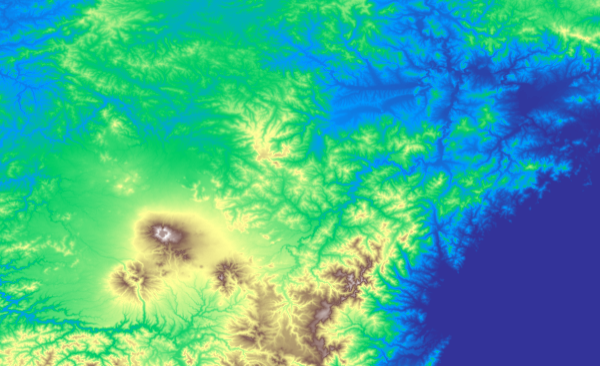

In [4]:
# ==============================================================================
# 4. Visualization (Interactive Map)
# ==============================================================================
print("\n🔵 [Step 3] Visualization")

if final_dem_path:
    # 1. DEM 지형도 생성 (기본 지도 베이스)
    m1 = dem_man.plot_dem(max_pixels=600)
    
    if m1:
        # SLC 데이터로부터 교집합 폴리곤 다시 가져오기
        master_geojson = dm.results[master_idx].geojson()
        m_poly = shape(master_geojson['geometry'])
        s_polys = [shape(dm.results[i].geojson()['geometry']) for i in dm.selected_indices if i != master_idx]
        intersection_poly = m_poly.intersection(unary_union(s_polys))

        # ---------------------------------------------------------
        # 2. 교집합 영역 (Intersection) - 최우선 순위로 추가
        # ---------------------------------------------------------
        if not intersection_poly.is_empty:
            # 보라색(Purple) 계열은 녹색/갈색 지형도 위에서 아주 눈에 잘 띕니다.
            folium.GeoJson(
                mapping(intersection_poly),
                style_function=lambda x: {
                    'color': '#ff00ff',      # 마젠타(형광 보라) 외곽선
                    'weight': 5,             # 아주 굵게
                    'fillColor': '#ff00ff',  # 채우기
                    'fillOpacity': 0.3,      # 투명도
                },
                tooltip="Target Intersection Area",
                name="[CORE] Intersection Area"
            ).add_to(m1)
            
            # ---------------------------------------------------------
            # 3. 개별 SLC 경계선 (점선으로 표시)
            # ---------------------------------------------------------
            # Master Frame (Green)
            folium.GeoJson(
                master_geojson,
                style_function=lambda x: {'color': '#2ecc71', 'fill': False, 'weight': 2, 'dashArray': '10, 10'},
                name="Master SLC Frame"
            ).add_to(m1)
            
            # Slave Frames (Yellow)
            for idx in dm.selected_indices:
                if idx == master_idx: continue
                folium.GeoJson(
                    dm.results[idx].geojson(),
                    style_function=lambda x: {'color': '#f1c40f', 'fill': False, 'weight': 2, 'dashArray': '10, 10'},
                    name=f"Slave SLC Frame ({idx})"
                ).add_to(m1)

            # 지도를 교집합 영역으로 강제 줌인
            b = intersection_poly.bounds  # (minx, miny, maxx, maxy)
            # fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
            m1.fit_bounds([[b[1], b[0]], [b[3], b[2]]])
            
            print(f"✅ Intersection Polygon successfully added to map.")
        else:
            print("⚠️ Intersection is empty. Please check your SLC selection.")

        # 레이어 컨트롤을 펼쳐서 표시 (사용자가 직접 껐다 켰다 해보세요)
        folium.LayerControl(collapsed=False).add_to(m1)
        
        display(m1)